In [460]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import RidgeCV,LassoCV,ElasticNetCV


from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [408]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")
    
def eval_preds(y_true, y_pred,graph=False):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse}")
    print(f"mae {mae}")
    print(f"mape {mape}")
    
    if graph==True:
        line_pts = [y_true.min(), y_true.max()]
        plt.scatter(y_true, y_pred)
        plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
        plt.xlabel("Actual")
        plt.ylabel("Fit")
        plt.show()


In [435]:
#Loading the dataset and manipulating the variables

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()
drop_cols=[]
for col in df.columns:
    if df[col].isna().mean()>.4:
        drop_cols=drop_cols+[col]
df_clean=df.drop(columns=drop_cols).dropna()
df_clean['secondflrexists']=0
df_clean.loc[df['secondflrsf']>0,'secondflrexists']=1 #can prob drop 2nd fl sq ft
#df_clean['totalsf']=df_clean['firstflrsf']=+df_clean['secondflrsf']
df_clean['yrsbltqared']=df_clean['yearbuilt']*df_clean['yearbuilt']
df_clean['agebuilt']=df_clean['yrsold']-df_clean['yearbuilt']
df_clean['ageremodeled']=df_clean['yrsold']-df_clean['yearremodadd']
df_clean['agebuiltsquared']=df_clean['agebuilt']*df_clean['agebuilt']
df_clean['agebuiltcubed']=df_clean['agebuilt']*df_clean['agebuilt']*df_clean['agebuilt']

df_clean['logagebuilt']=np.log1p(df_clean['agebuilt'])
df_clean['logageremodeled']=np.log1p(df_clean['ageremodeled'])

df_clean['garageage']=df_clean['yrsold']-df_clean['garageyrblt']
df_clean['garageagesquared']=df_clean['garageage']**2

####
df_clean['overallqualsquared']=df_clean['overallqual']*df_clean['overallqual']
df_clean['overallqualcubed']=df_clean['overallqual']*df_clean['overallqual']*df_clean['overallqual']
#df_clean['logqualsquared']=np.log(df_clean['overallqualsquared'])
df_clean['logqual']=np.log(df_clean['overallqual'])
df_clean['squaredlogqual']=df_clean['logqual']*df_clean['logqual']

df_clean['grlivareasquared']=df_clean['grlivarea']*df_clean['grlivarea']
df_clean['loggrlivarea']=np.log(df_clean['grlivarea'])
df_clean['squaredlogarea']=df_clean['loggrlivarea']*df_clean['loggrlivarea']


df_clean['ageremodeledsquared']=df_clean['ageremodeled']*df_clean['ageremodeled']
df_clean['ageremodeledcubed']=df_clean['ageremodeled']*df_clean['ageremodeled']

df_clean['totalsf']=df_clean['totalbsmtsf']+df_clean['grlivarea']
df_clean['qual_totalsf']=df_clean['totalsf']*df_clean['overallqual']

df_clean['lotareasquared']=df_clean['lotarea']*df_clean['lotarea']

#making partial,centralair and the neighborhood a binary variable
niceneighborhoods=['NridgHt', 'NoRidge', 'Somerst', 'Timber', 'Veenker', 'StoneBr']
goodneighborhoods=['ClearCr','Crawfor','CollgCr','Gilbert','Blmngtn','SawyerW','NWAmes']

df_clean['nicehood']=0
df_clean.loc[df_clean.neighborhood.isin(niceneighborhoods),'nicehood']=1
df_clean['hoodrank']=0
df_clean.loc[df_clean.neighborhood.isin(goodneighborhoods),'hoodrank']=1
df_clean.loc[df_clean.neighborhood.isin(niceneighborhoods),'hoodrank']=2
df_clean['goodhood']=0
df_clean.loc[df_clean.neighborhood.isin(goodneighborhoods),'goodhood']=1

#Making binary cats ints
df_clean['sale_partial']=0
df_clean.loc[df_clean.salecondition=='Partial','sale_partial']=1
df_clean['centralairint']=0
df_clean.loc[df_clean.centralair=='Y','centralairint']=1
# df_clean['pavedstreet']=0
# df_clean.loc[df_clean.salecondition=='Pave','pavedstreet']=1


#one hot encoding neighborhood
#df_clean = pd.concat([df_clean,pd.get_dummies(df_clean.neighborhood, prefix="hood", drop_first=True)], axis=1)

In [436]:
#Dropping outliers of high leveridge
df_clean=df_clean.drop([314,523,1298,452])

In [450]:
#Setting up the model
# Right hashtag indicates vars I'm iffy on
cat_cols=['nicehood','goodhood','centralairint','salepartial']
num_cols=['overallqual',
          'overallqualsquared',
          'overallqualcubed',
          'grlivarea',
          'totalbsmtsf',
          'garagearea',
          'lotarea',
          'lotareasquared',
          'ageremodeled',
          'ageremodeledsquared',
          'agebuilt',
          'agebuiltsquared',
          'bedroomabvgr']

X = df_clean[['overallqual',
              'overallqualsquared',#
              'overallqualcubed',#
              'grlivarea',
#               'grlivareasquared',#
#               'loggrlivarea',#
               'totalbsmtsf',
               #'totalsf',#
               'garagearea', 
               'lotarea',
              'lotareasquared',
              'nicehood',
              'goodhood',
#               'hoodrank',#
               'ageremodeled',
               'ageremodeledsquared',
#               'ageremodeledcubed',#
#               'logageremodeled',##
               'agebuilt',
               'agebuiltsquared',
#               'logagebuilt',##
               'sale_partial',#
              'centralairint',
#               'newsale',#
              'bedroomabvgr',#
#                'yrsold',
              ]]
y = df_clean.saleprice
y_log=np.log(y)
X_train, X_test, y_log_train, y_log_test=train_test_split(X,y_log,test_size=.2,random_state=1)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
results_log = sm.OLS(y_log_train, X_train_const).fit()
print(results_log.summary())
y_log_preds=results_log.predict(X_test_const)
y_log_train_preds=results_log.predict(X_train_const)

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     393.1
Date:                Thu, 03 Sep 2020   Prob (F-statistic):               0.00
Time:                        00:55:54   Log-Likelihood:                 510.81
No. Observations:                 872   AIC:                            -985.6
Df Residuals:                     854   BIC:                            -899.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.1228    

In [451]:
print("Mean absolute error of the training set is: {}".format(mean_absolute_error(y_log_train, y_log_train_preds)))
print("Mean squared error of the training set is: {}".format(mse(y_log_train, y_log_train_preds)))
print("Root mean squared error of the training set is: {}".format(rmse(y_log_train, y_log_train_preds)))
print("Mean absolute percentage error of the training set is: {}".format(np.mean(np.abs((y_log_train - y_log_train_preds) / y_log_train)) * 100))


Mean absolute error of the training set is: 0.09748812970663243
Mean squared error of the training set is: 0.018143047315407477
Root mean squared error of the training set is: 0.13469612954872712
Mean absolute percentage error of the training set is: 0.8150226606774564


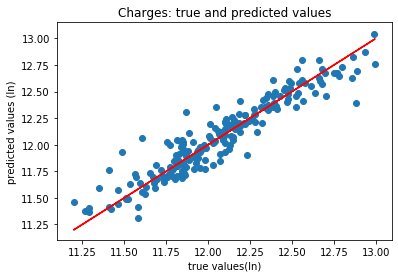

Mean absolute error of the prediction is: 0.09010431816013759
Mean squared error of the prediction is: 0.015696584885429826
Root mean squared error of the prediction is: 0.12528601232950878
Mean absolute percentage error of the prediction is: 0.7483121664435822


In [452]:
plt.scatter(y_log_test, y_log_preds)
plt.plot(y_log_test, y_log_test, color="red")
plt.xlabel("true values(ln)")
plt.ylabel("predicted values (ln)")
plt.title("Charges: true and predicted values")
plt.show()
y_test= np.exp(y_log_test)
y_preds=np.exp(y_log_preds)

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_log_test, y_log_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_log_test, y_log_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_log_test, y_log_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_log_test - y_log_preds) / y_log_test)) * 100))


In [453]:
# for col in X:
#     plt.hist(X[col])
#     plt.title(col)
#     plt.show()

***Try OLS, Lasso, Ridge, and ElasticNet regression using the same model specification. This time, you need to do k-fold cross-validation to choose the best hyperparameter values for your models. Scikit-learn has RidgeCV, LassoCV, and ElasticNetCV that you can utilize to do this. Which model is the best? Why?***


Ridge first:

In [454]:
#can't get this to work

# ct = ColumnTransformer(
#     [
#         ("scale", StandardScaler(), num_cols),
#     ],
#     remainder="passthrough",
# )
# ct.fit(X_train)

# X_train_trans = ct.transform(X_train)
# X_test_trans = ct.transform(X_test)
# cat_names = ct.transformers_[0][1].get_feature_names(cat_cols)
# cat_names = list(cat_names)
# new_col_names = cat_names + num_cols + bin_cols

# X_train = pd.DataFrame(X_train_trans, columns=new_col_names)
# X_test = pd.DataFrame(X_test_trans, columns=new_col_names)

ct = ColumnTransformer(
    [
        ("scale", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
)
ct.fit(X_train)

X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)
X_test=pd.DataFrame(X_test_trans)
X_train=pd.DataFrame(X_train_trans)


In [455]:
col_list = num_cols+cat_cols
X_test.columns=col_list
X_train.columns=col_list
print(X_train.shape)
print(y_log_train.shape)

(872, 17)
(872,)


In [456]:
linear = LinearRegression()
linear.fit(X_train, y_log_train)

ridge = Ridge(alpha=10)
ridge.fit(X_train, y_log_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [457]:
print(f"LinearRegression Train R^2: {linear.score(X_train, y_log_train)}")
print(f"LinearRegression Test R^2: {linear.score(X_test, y_log_test)}")

print(f"\nRidge Train R^2: {ridge.score(X_train, y_log_train)}")
print(f"Ridge Test R^2: {ridge.score(X_test, y_log_test)}")

LinearRegression Train R^2: 0.8866980088947074
LinearRegression Test R^2: 0.8855470452351183

Ridge Train R^2: 0.8845186676978815
Ridge Test R^2: 0.8862977829453141


In [458]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

print("Train\n---------------------------------")
eval_preds(y_log_train, y_pred_train)
print("Test\n---------------------------------")
eval_preds(y_log_test, y_pred_test)

Train
---------------------------------
rmse 0.13598538602082652
mae 0.09783010060640249
mape 0.008181169511291116
Test
---------------------------------
rmse 0.12487444720003538
mae 0.09031869509522569
mape 0.007502640634355899


In [482]:
regr_cv = RidgeCV(alphas=[.01,.02,.04,.06,.08,.1,.2, 1.0,], cv=5)
model_cv = regr_cv.fit(X_train, y_log_train)
print(model_cv.score(X_test,y_log_test))
print(model_cv.alpha_)

0.8858804200367465
0.06


In [486]:
regr_cv = LassoCV(alphas=[0,.00001,.0001,.001,.01,.1,1.0,10,100], cv=5)
model_cv = regr_cv.fit(X_train, y_log_train)
print(model_cv.score(X_test,y_log_test))
print(model_cv.alpha_)

0.886088352777824
0.0


Seems like it just likes linear regression

In [488]:
grid = {
    "alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "l1_ratio": [0.25, 0.5, 0.75, 1.0],
}

model = GridSearchCV(ElasticNet(), grid)
model.fit(X_train, y_log_train)

print(f"train score: {model.score(X_train, y_log_train)}")
print(f"test score: {model.score(X_test, y_log_test)}")
model.best_params_

train score: 0.8853163204956821
test score: 0.8861243025167382


{'alpha': 0.001, 'l1_ratio': 0.25}

Seems like the elasticnet got the slightly higher R squared score

In [492]:
y_log_predict=model.predict(X_test)
#model.cv_results_
#model.mean_squared_error(y_log_test,y_log_predict)

In [494]:
alphas=[.001,.01,.1,1]
lasso_cv=LassoCV(alphas=alphas,cv=5)
lasso_cv.fit(X_train, y_log_train)
y_preds_test=lasso_cv.predict(X_test)